In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_model, make_model_weighted
# from kgcnn.layers.ragged.pooling import PoolingWeightedNodes
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import LinearLearningRateScheduler

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.datasets.mutagenicity import MutagenicityDataset

## Load Data

In [2]:
dataset = MutagenicityDataset()
labels, nodes, edge_indices, edges, atoms = dataset.graph_labels, dataset.node_attributes, dataset.edge_indices, dataset.edge_attributes, dataset.node_number
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32)# Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

INFO:kgcnn: Dataset directory located at C:\Users\Patrick\.kgcnn\datasets
INFO:kgcnn: Dataset directory found... done
INFO:kgcnn: Dataset found... done
INFO:kgcnn: Directory for extraction exists... done
INFO:kgcnn: Not extracting zip file ... stopped
INFO:kgcnn: Shift start of graph id to zero for Mutagenicity to match python indexing.
INFO:kgcnn: Graph index which has unconnected [  38  133  166  171  220  246  268  278  286  296  302  305  309  339
  357  439  470  497  527  706  743  783  815  861  878  902  918 1029
 1040 1044 1057 1085 1193 1233 1329 1394 1431 1525 1528 1532 1609 1645
 1696 1915 1971 2024 2026 2036 2069 2133 2138 2142 2143 2174 2193 2210
 2234 2258 2360 2422 2440 2471 2482 2483 2503 2553 2559 2604 2627 2673
 2687 2720 2738 2808 2824 2878 2925 2959 3012 3018 3034 3037 3051 3079
 3114 3118 3142 3208 3217 3310 3344 3349 3371 3380 3381 3395 3477 3498
 3534 3538 3556 3571 3677 3683 3701 3782 3827 3855 3863 3869 3938 3955
 3971 4019 4030 4036 4051 4075 4131 4267 4331] 

## Load and train model

INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 14)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                'use_bias': [True, True, False]},
 'verbose': 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_attributes (InputLayer)    [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 64)     960         node_attributes[0][0]            
__________________________________________________________________________________________________
edge_attributes (InputLayer)    [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
edge_indices (InputLayer)       [(None, None, 2)]    0                                            
______________________________________________________________________________________________

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), d

109/109 - 3s - loss: 0.6660 - accuracy: 0.5970
Epoch 2/150
109/109 - 1s - loss: 0.6205 - accuracy: 0.6777
Epoch 3/150
109/109 - 1s - loss: 0.6034 - accuracy: 0.6941
Epoch 4/150
109/109 - 1s - loss: 0.5906 - accuracy: 0.6996
Epoch 5/150
109/109 - 1s - loss: 0.5662 - accuracy: 0.7106
Epoch 6/150
109/109 - 1s - loss: 0.5415 - accuracy: 0.7308
Epoch 7/150
109/109 - 1s - loss: 0.5339 - accuracy: 0.7342
Epoch 8/150
109/109 - 1s - loss: 0.5299 - accuracy: 0.7403
Epoch 9/150
109/109 - 1s - loss: 0.5293 - accuracy: 0.7331
Epoch 10/150
109/109 - 2s - loss: 0.5189 - accuracy: 0.7518 - val_loss: 0.5210 - val_accuracy: 0.7512
Epoch 11/150
109/109 - 1s - loss: 0.5030 - accuracy: 0.7555
Epoch 12/150
109/109 - 1s - loss: 0.5090 - accuracy: 0.7495
Epoch 13/150
109/109 - 1s - loss: 0.4930 - accuracy: 0.7616
Epoch 14/150
109/109 - 1s - loss: 0.4993 - accuracy: 0.7538
Epoch 15/150
109/109 - 1s - loss: 0.4959 - accuracy: 0.7593
Epoch 16/150
109/109 - 1s - loss: 0.4865 - accuracy: 0.7656
Epoch 17/150
109/10

109/109 - 1s - loss: 0.1397 - accuracy: 0.9455
Epoch 130/150
109/109 - 1s - loss: 0.1275 - accuracy: 0.9524 - val_loss: 0.8529 - val_accuracy: 0.8018
Epoch 131/150
109/109 - 1s - loss: 0.1296 - accuracy: 0.9498
Epoch 132/150
109/109 - 1s - loss: 0.1196 - accuracy: 0.9536
Epoch 133/150
109/109 - 1s - loss: 0.1209 - accuracy: 0.9536
Epoch 134/150
109/109 - 1s - loss: 0.1148 - accuracy: 0.9573
Epoch 135/150
109/109 - 1s - loss: 0.1142 - accuracy: 0.9602
Epoch 136/150
109/109 - 1s - loss: 0.1163 - accuracy: 0.9582
Epoch 137/150
109/109 - 1s - loss: 0.1060 - accuracy: 0.9588
Epoch 138/150
109/109 - 1s - loss: 0.1053 - accuracy: 0.9591
Epoch 139/150
109/109 - 1s - loss: 0.1002 - accuracy: 0.9619
Epoch 140/150
109/109 - 1s - loss: 0.1084 - accuracy: 0.9594 - val_loss: 0.9211 - val_accuracy: 0.8041
Epoch 141/150
109/109 - 1s - loss: 0.0997 - accuracy: 0.9637
Epoch 142/150
109/109 - 1s - loss: 0.0959 - accuracy: 0.9668
Epoch 143/150
109/109 - 1s - loss: 0.0949 - accuracy: 0.9631
Epoch 144/150
1

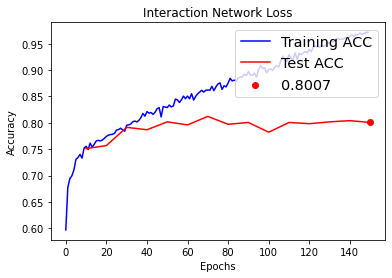

In [3]:
model_args = {'name': "GCN",
                 'inputs': [{'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
                 'input_embedding': {"node": {"input_dim": 55, "output_dim": 64},
                                     "edge": {"input_dim": 10, "output_dim": 64}},
                 'output_embedding': 'graph',
                 'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                                "activation": ['relu', 'relu', 'sigmoid']},
                 'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean',
                              "is_sorted": False, "has_unconnected": True},
                 'depth': 3, 'verbose': 1
              }
model_args2 = {'name': "GCN_weighted",
              'inputs': [{'shape': (None, 14), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
                         {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
                         {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True},
                         {'shape': (None, 1), 'name': "node_weights", 'dtype': 'float32', 'ragged': True}],
              'input_embedding': {"node": {"input_dim": 55, "output_dim": 64},
                                  "edge": {"input_dim": 10, "output_dim": 64}},
              'output_embedding': 'graph',
              'output_mlp': {"use_bias": [True, True, False], "units": [140, 70, 1],
                             "activation": ['relu', 'relu', 'sigmoid']},
              'gcn_args': {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean',
                           "is_sorted": False, "has_unconnected": True},
              'depth': 3, 'verbose': 1
              }
model = make_model(**model_args)
model_node_weights = make_model_weighted(**model_args2)
# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_2.png')
plt.show()

## We have to implement the ExplainableGCN from the GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()

        # Here we modify the gcn model to allow node weights
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        node_input, edge_input, edge_index_input = gnn_input
        node_weights = tf.RaggedTensor.from_row_splits(tf.expand_dims(tf.ones_like(node_input.values)[:,0],axis=-1), node_input.row_splits)
        return self.gnn_model([node_input, edge_input, edge_index_input, node_weights], training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = edge_mask * edge_input[0]
        masked_edge_input = tf.RaggedTensor.from_row_splits(masked_edge_input, [0, len(masked_edge_input)])
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        node_weights = tf.RaggedTensor.from_row_splits(tf.sigmoid(node_mask), np.array([0, len(node_mask)],dtype=np.int))

        masked_pred = self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input, node_weights],
                                     training=training)[0]
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

In [5]:
# Transfer weights
model_node_weights.set_weights(model.get_weights())
# Instanciate a Explainable GNN:
explainable_gcn = ExplainableGCN(model_node_weights)

In [6]:
# Find the 100 most mutagenic molecules, according to the GNN:
pred = model.predict(xtest)[:,0]
print(np.argsort(pred)[:100])

# Select instance to explain
instance_index = 297

[333  63 652 126 537 466 379 500 848 118  85  68 653 602 105 260 595 264
 512 143 761 478 554  90  43 550 635 699 336 387 862 496 723 367  59 633
 244  87 839 103 808 859 418 116  55 805 233 840 762 297 317 779 543 347
  36 443 360 183 715 811 571 202 152 100 248 737 857 830 832 324 452 467
 187 272 284  67 212 282   1 408 597 417 790 218 497  58 649  37 383 670
 361  34 534 176 706 567 307 515 313 488]


Setup an GNNExplainer and explain the instance:

In [7]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.1)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.005,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0.0001,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0.0001,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest])
#explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pyth

<Figure size 432x288 with 0 Axes>

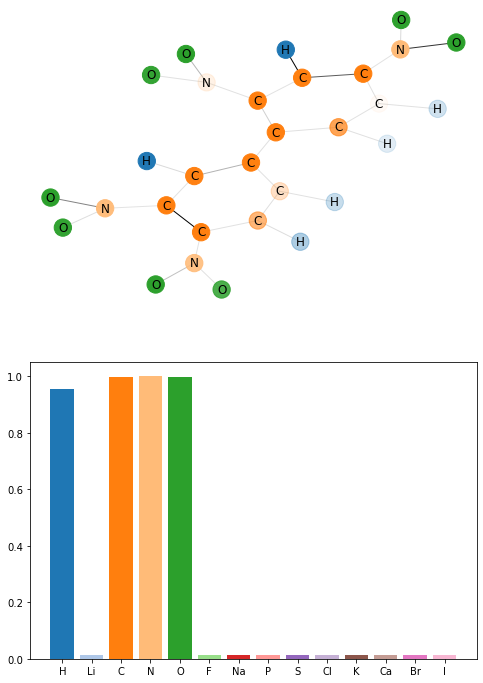

In [8]:
# Let's look at the explanation the GNNExplainer found:
plt.figure()
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()

If we do not specify the output_to_explain as parameter to the explain method the Explainer
will explain why the GNN came to its conclusion.
For molecules which are classified as non-mutagenic by the GNN,
the GNNExplainer will then explain why they are non-mutagenic.
We can also specify output_to_explain to be tf.Variable([0.]).
This way we can tell the Explainer to explain why a molecule could be mutagenic
even for molecules which are classified as most likely non-mutagenic by the GNN):

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_4/gather_nodes_outgoing_4/Reshape_1:0", shape=(None,), dtype=int64), value

<Figure size 432x288 with 0 Axes>

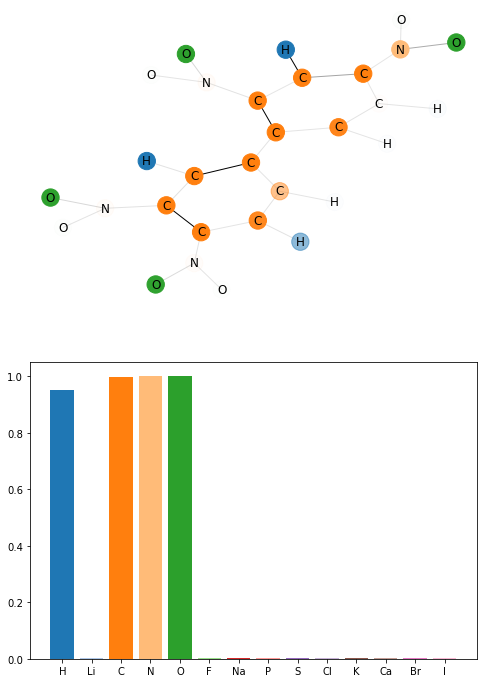

In [9]:
plt.figure()
explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()